# Testing normalizing flows:

In [1]:
# Import packages
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import normflows as nf

from sklearn.datasets import make_moons

from matplotlib import pyplot as plt

from tqdm import tqdm

Setting up device to GPU:

In [2]:
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')

## Testing normalizing flows for estimating $f(x)$:

Setting up normalizing flows with Autoregressive Rational Quadratic Spline flow and gaussian base distribution:

In [36]:
# Define flows
K = 16
torch.manual_seed(0)

latent_size = 2
hidden_units = 128
hidden_layers = 2

flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set base distribuiton
q0 = nf.distributions.DiagGaussian(2, trainable=False)
    
# Construct flow model
nfm = nf.NormalizingFlow(q0=q0, flows=flows)

# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
nfm = nfm.to(device)

Simulating data with a moon-like shape:

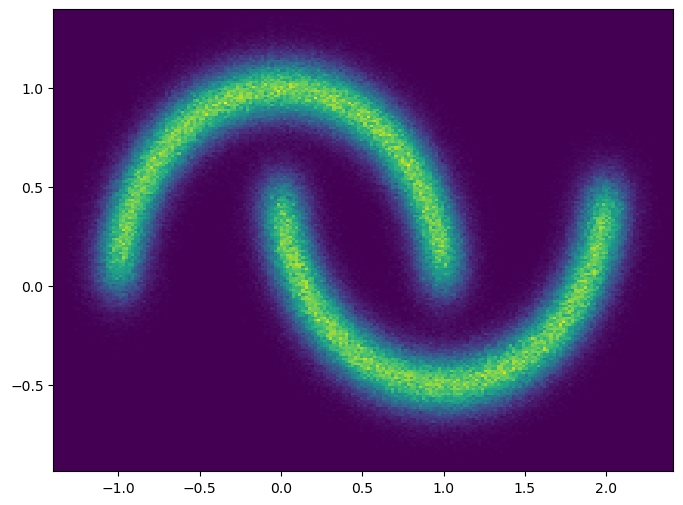

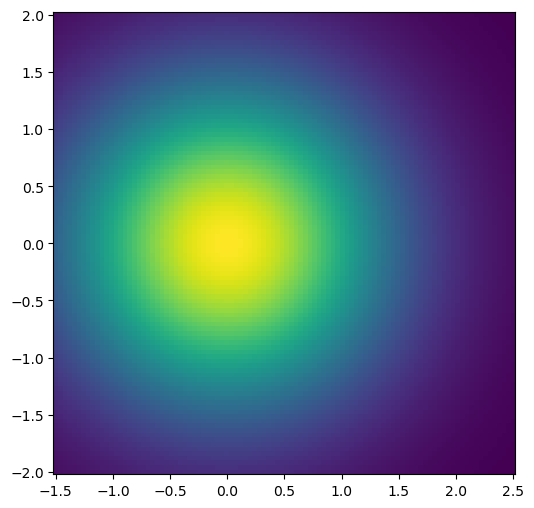

In [37]:
# Plot target distribution
x_np, _ = make_moons(2 ** 20, noise=0.1)
plt.figure(figsize=(8, 6))
plt.hist2d(x_np[:, 0], x_np[:, 1], bins=200)
plt.show()

# Plot initial flow distribution
grid_size = 100
xx, yy = torch.meshgrid(torch.linspace(-1.5, 2.5, grid_size), torch.linspace(-2, 2, grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
zz = zz.to(device)

nfm.eval()
log_prob = nfm.log_prob(zz).to('cpu').view(*xx.shape)
nfm.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(8, 6))
plt.pcolormesh(xx, yy, prob.data.numpy())
plt.gca().set_aspect('equal', 'box')
plt.show()

100%|██████████| 1000/1000 [01:53<00:00,  8.82it/s]


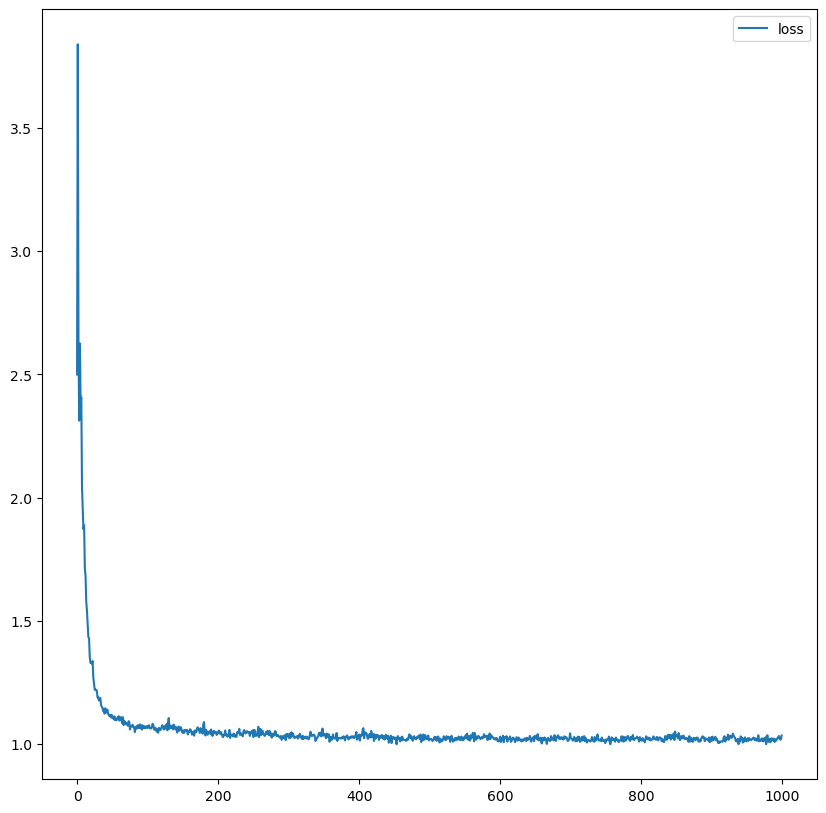

In [38]:
# Train model
max_iter = 1000
num_samples = 10 ** 4
show_iter = 500

# generating samples one single time
x_np, _ = make_moons(num_samples, noise = 0.1)

loss_hist = np.array([])

optimizer = torch.optim.Adam(nfm.parameters(), lr=1e-3, weight_decay=1e-5)
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    
    # Get training samples
    x_np, _ = make_moons(num_samples, noise=0.1)
    x = torch.tensor(x_np).float().to(device)
    
    # Compute loss
    loss = nfm.forward_kld(x)
    
    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()
    
    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
    
    # Plot learned distribution
    #if (it + 1) % show_iter == 0:
     #   nfm.eval()
      #  log_prob = nfm.log_prob(zz)
       # nfm.train()
        #prob = torch.exp(log_prob.to('cpu').view(*xx.shape))
        #prob[torch.isnan(prob)] = 0

        #plt.figure(figsize=(15, 15))
        #plt.pcolormesh(xx, yy, prob.data.numpy())
        #plt.gca().set_aspect('equal', 'box')
        #plt.show()

# Plot loss
plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

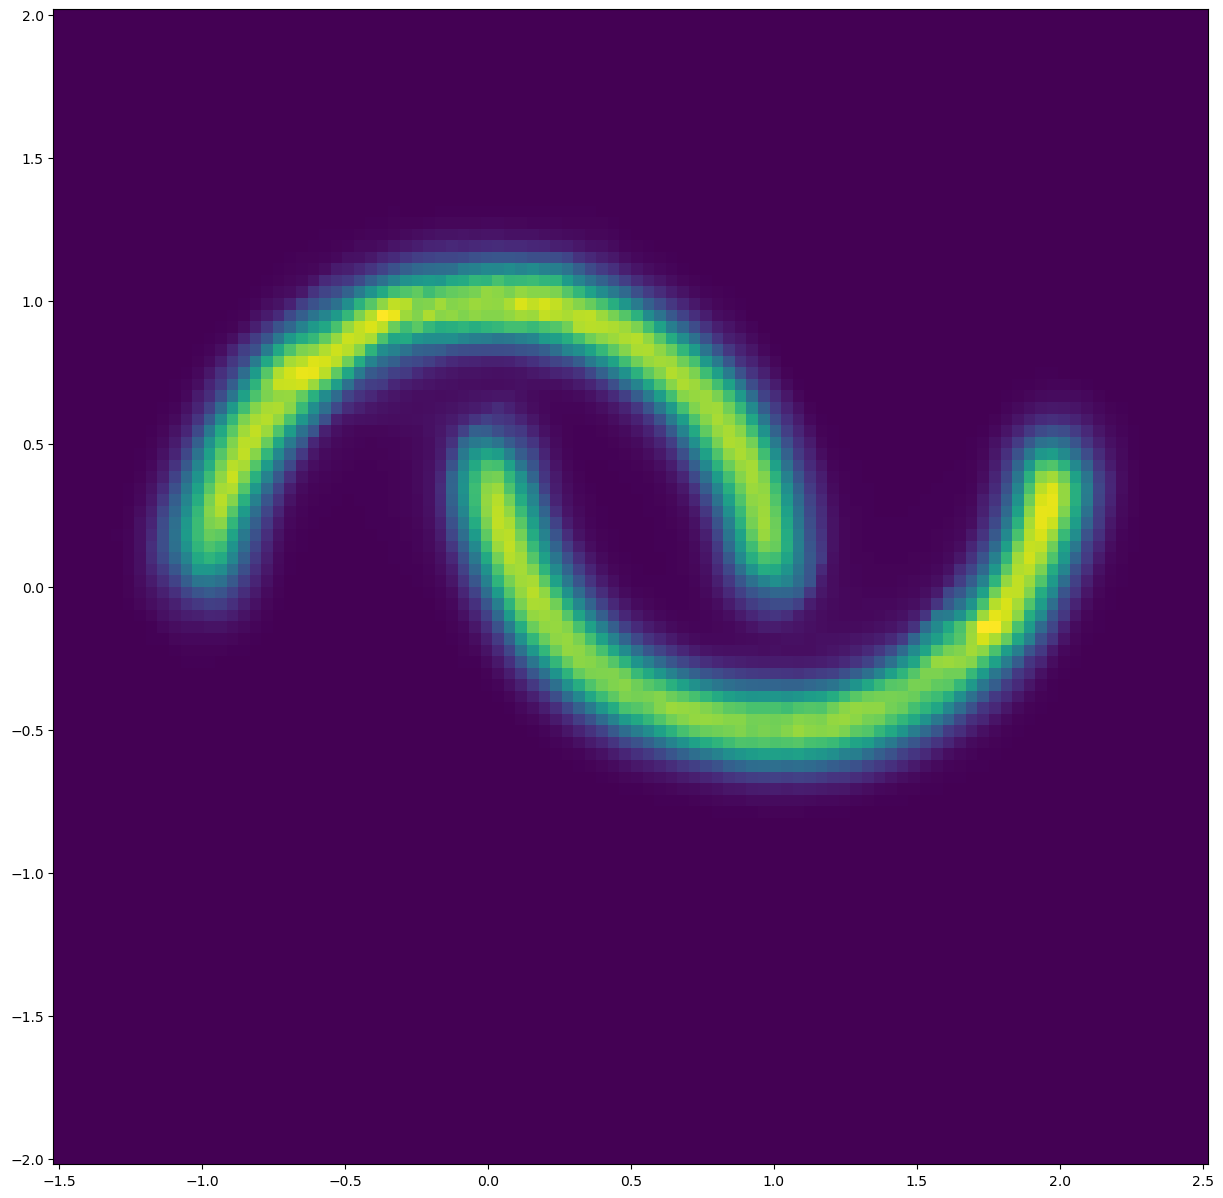

In [39]:
# Plot learned distribution
nfm.eval()
log_prob = nfm.log_prob(zz).to('cpu').view(*xx.shape)
nfm.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(15, 15))
plt.pcolormesh(xx, yy, prob.data.numpy())
plt.gca().set_aspect('equal', 'box')
plt.show()

In [40]:
s, _ = nfm.sample(1000)

## Now, using it to learn a conditional distribution $f(y|x)$

The target is a 2d normal distribution conditioned on $c = (\mu, \sigma^2)$, plotting for $\mu = (0.3, 0.9)$ and $\sigma = (0.6, 0.6)$

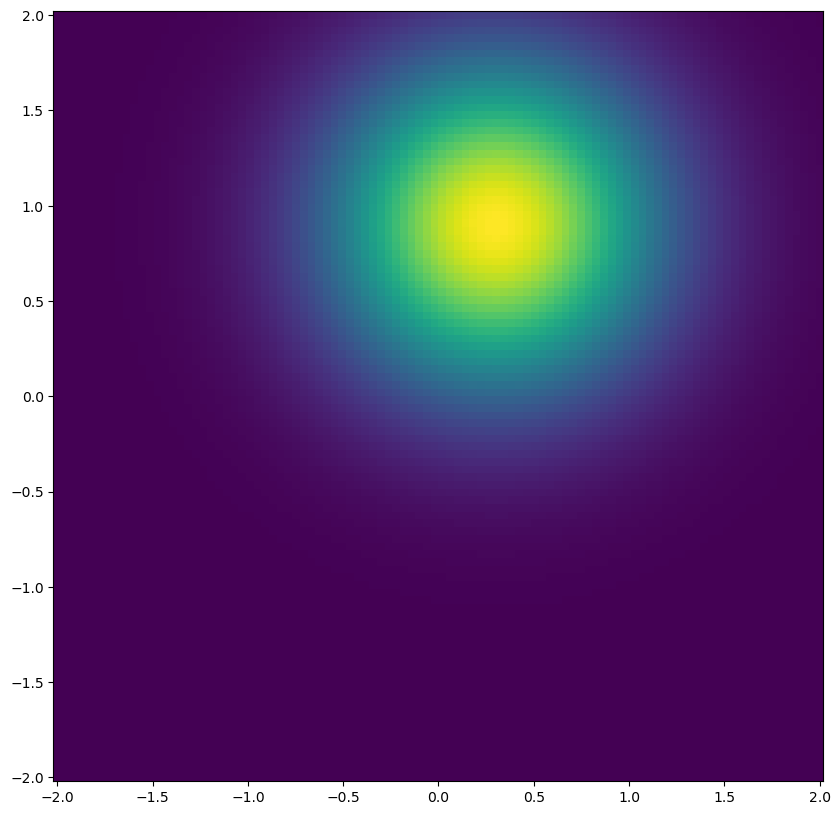

In [3]:
# Define target
target = nf.distributions.target.ConditionalDiagGaussian()

# Plot target
grid_size = 100
xx, yy = torch.meshgrid(torch.linspace(-2, 2, grid_size), torch.linspace(-2, 2, grid_size), indexing='ij')
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
zz = zz.to(device)
context_plot = torch.cat([torch.tensor([0.3, 0.9]).to(device) + torch.zeros_like(zz), 
                          0.6 * torch.ones_like(zz)], dim=-1)
logp = target.log_prob(zz, context_plot)
p_target = torch.exp(logp).view(*xx.shape).cpu().data.numpy()

plt.figure(figsize=(10, 10))
plt.pcolormesh(xx, yy, p_target, shading='auto')
plt.gca().set_aspect('equal', 'box')
plt.show()

Setting up the normalizing flow model:

In [4]:
# setting up model
context_size = 4
K = 8
torch.manual_seed(0)
latent_size = 2
hidden_units = 128
hidden_layers = 2


flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units, 
                                                             num_context_channels=context_size)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set base distribution
q0 = nf.distributions.DiagGaussian(2, trainable=False)
    
# Construct flow model
model = nf.ConditionalNormalizingFlow(q0, flows)

# Move model on GPU if available
model = model.to(device)

Generating a single large dataset and selecting only a batch of data:

In [5]:
# Train model
max_iter = 2000
batch_size = 200
n_train = 20000
# patience for early stopping
patience = 100

# simulating dataset
context = torch.cat([torch.randn((n_train, 2), device=device), 
                         0.5 + 0.5 * torch.rand((n_train, 2), device=device)], 
                        dim=-1)

x = target.sample(n_train, context)

# splitting into train and validation
dataset = TensorDataset(context, x)
train_set, val_set = torch.utils.data.random_split(dataset, [15000, 5000])

train_loader, val_loader = DataLoader(train_set, shuffle=True, batch_size = batch_size), DataLoader(val_set, shuffle=True, batch_size = batch_size)

loss_hist = np.array([])
avg_loss_list = []
best_loss_history = []

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
best_loss = np.inf

 52%|█████▏    | 1047/2000 [07:46<07:04,  2.24it/s]

Early stopping at epoch 1047


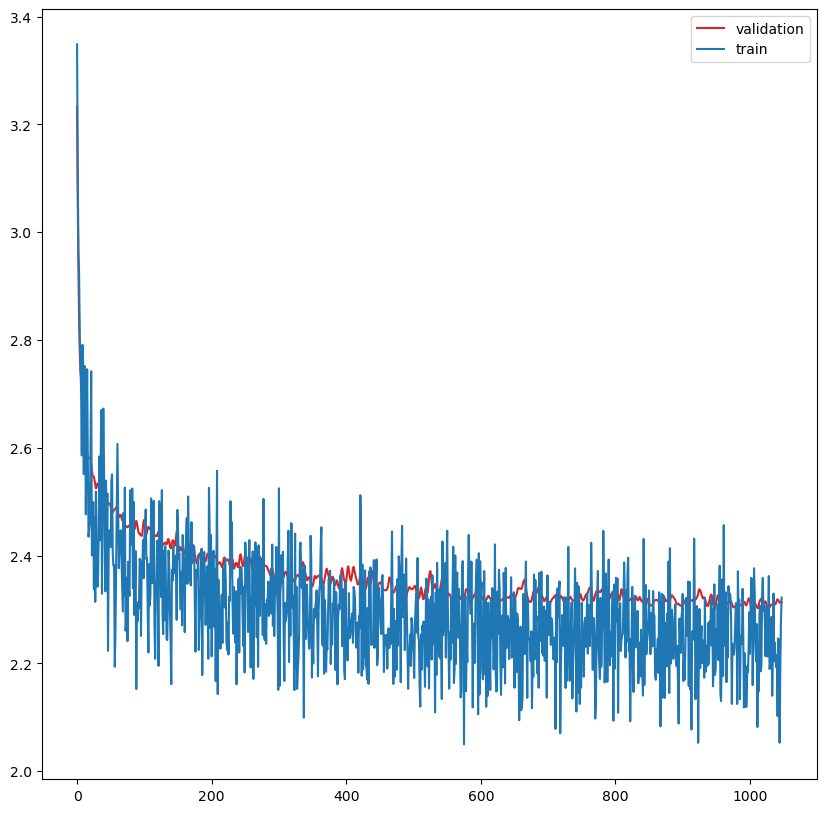

In [6]:
loss_vals_train = []
avg_loss_val_list = []
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    loss_val_list = []
    # iterating train data loader
    context, x = iter(train_loader).__next__()
    context.requires_grad_(True)
    
    loss = model.forward_kld(x, context)
    loss_value = loss.to('cpu').data.numpy()
    loss_vals_train.append(loss_value)
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()
    
    # validating in validation data loader
    for context, x in val_loader:
         with torch.no_grad():
              model.eval()
              loss = model.forward_kld(x, context)
              loss_value = loss.to('cpu').data.numpy()
              loss_val_list.append(loss_value)
    avg_loss_val = np.mean(loss_val_list)
    avg_loss_val_list.append(avg_loss_val)

    if avg_loss_val < best_loss:
        best_loss = avg_loss_val
        best_loss_history.append(best_loss)
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {it}")
            break
    model.train()

loss_hist_val = np.array(avg_loss_val_list)
loss_hist_train = np.array(loss_vals_train)
# Plot loss
plt.figure(figsize=(10, 10))
plt.plot(loss_hist_val, label='validation', color = "tab:red")
plt.plot(loss_hist_train, label = "train", color = "tab:blue")
plt.legend()
plt.show()

### Plotting for the already specified context:

In [12]:
model.eval()
log_prob = model.log_prob(zz, context_plot).to('cpu')
model.train()
log_prob.detach().numpy()

array([-15.5392   , -15.540023 , -15.536642 , ...,  -5.8859487,
        -5.9651732,  -6.047888 ], dtype=float32)

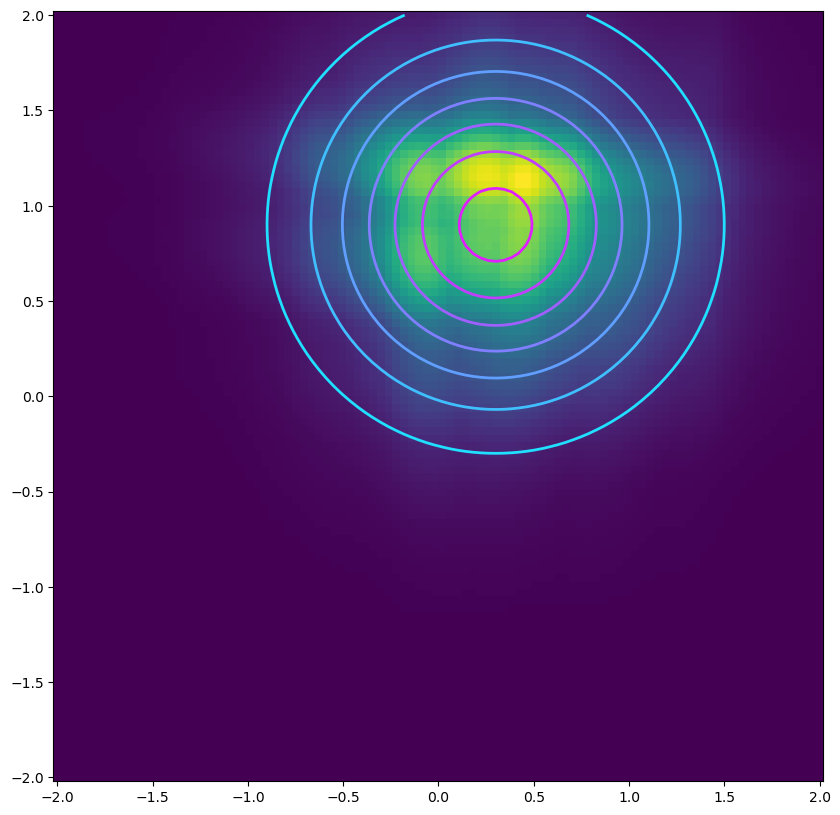

In [13]:
# Plot trained flow distribution, target as contours
model.eval()
log_prob = model.log_prob(zz, context_plot).to('cpu').view(*xx.shape)
model.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(10, 10))
plt.pcolormesh(xx, yy, prob.data.numpy(), shading='auto')
plt.contour(xx, yy, p_target, cmap=plt.get_cmap('cool'), linewidths=2)
plt.gca().set_aspect('equal', 'box')
plt.show()

In [9]:
torch.tensor([0.3, 0.9, 0.6, 0.6]).to(device).reshape(1, -1)

tensor([[0.3000, 0.9000, 0.6000, 0.6000]], device='cuda:0')

In [10]:
# sampling from estimated distribution to compute posterior mean
with torch.no_grad():
    s, _ =model.sample(context = torch.tensor([0.3, 0.9, 0.6, 0.6]).to(device).reshape(1, -1), num_samples = 1)
s

tensor([[0.4715, 0.0645]], device='cuda:0')

In [11]:
s.to('cpu').numpy()

array([[0.47147128, 0.06446982]], dtype=float32)